### Underlying Data Stuff

All the stuff needed to represent the algorithm; like the basic datatypes and some helpers are here.

In [1]:
## Path Class definition.

class Path:
    def __init__(self):
        self.edges = []
        self.nodes = []

    def add_edge(self, edge):
        self.edges.append(edge)

    def add_edges(self, edges):
        self.edges.extend(edges)

    def add_node(self, node):
        self.nodes.append(node)

    def add_nodes(self, nodes):
        self.nodes.extend(nodes)

In [2]:
## Edge Class definition.

class Edge:
    def __init__(self, start_node, end_node):
        self.start = start_node
        self.end = end_node

In [3]:
## Node Class definition.

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y

### Algorithm Stuff

Anything pertaining to the actual algorithm (along with helper methods) I've come up with is in here.

The algorithm starts with a simple process:

1. Choose a <blue_t>starting point</blue_t>, and an <pink_t>ending point</pink_t>.
2. Create <orange>rooms</orange> from the <blue_t>starting point</blue_t> to the <pink_t>ending point</pink_t>.
3. Randomly nudge the <orange>rooms</orange>' positions around.
4. Create <les_pink>hallways</les_pink> between each neighboring <orange>room</orange>.

Let's call these four steps creating one <green>path</green>. Next:

1. Generate two <green>paths</green>, let's call one <blue>main</blue> and one <light_blue>alt</light_blue>.
2. Create a <les_pink>hallway</les_pink> between each <orange>room</orange> in <blue>main</blue> to the corresponding <orange>room</orange> in <light_blue>alt</light_blue>.
3. Delete an arbitrary percentage of random <orange>rooms</orange> from <light_blue>alt</light_blue>.
4. Delete any <les_pink>hallways</les_pink> that are missing a <orange>room</orange>.
5. Delete any <orange>rooms</orange> that are now orphaned from <blue>main</blue>.

Now, this will create a path that has a lot of loops and city block/"grid" style connections. We might not want that since it sorta removes mystery and any larger consequence for choosing path A or B, since they'll immediately end or continue forward. To address this, let's tune our process by adjusting step 3:

1. Reduce the arbitrary percent of <orange>rooms</orange> we delete from <light_blue>alt</light_blue>.
2. Randomly delete an arbitrary percent of <les_pink>hallways</les_pink> between <blue>main</blue> and <light_blue>alt</light_blue>.

In this implementation, I'm:

1. Representing each <orange>room</orange> as the Node class. A Node is just a point with an X and Y coordinate.
2. Representing each <les_pink>hallway</les_pink> as the Edge class. An Edge is just a connection between two nodes.

<style>
pink_t {
    color:#F5A9B8;
}
blue_t {
    color:#5BCEFA
}
white {
    color:#FFFFFF
}
orange {
    color:#EF7627
}
les_pink {
    color:#D162A4
}
green {
    color:#008026
}
blue {
    color:#004DFF
}
light_blue {
    color:#74D7EE
}
</style>

In [4]:
## Interpolate Helper.
# Generates points between a start and end node.

def interpolate(start_node, end_node, num_points, include_start=False, include_end=False):
    # Create the returned list.
    interpolated_points = []

    # Compute the offsets.
    intervals = num_points + 1
    offset_x = (end_node.x - start_node.x) / intervals
    offset_y = (end_node.y - start_node.y) / intervals

    # Generate the points.
    for i in range(num_points):
        x = start_node.x + offset_x * (i + 1)
        y = start_node.y + offset_y * (i + 1)
        interpolated_points.append(Node(x, y))

    # Optionally include the start and end points.
    if include_start:
        interpolated_points.insert(0, start_node)
    if include_end:
        interpolated_points.append(end_node)

    return interpolated_points

In [5]:
## Node Position Nudge Helper
# Adds random noise to the positions of nodes in a path.

import scipy.stats as stats

def fuzz_nodes(path, intensity=1.0, distribution=None, exclude_start=True, exclude_end=True):
    if distribution is None:
        # Discrete distribution.
        distribution = stats.norm(0, 0.5) # Mean 0, stddev 0.5

    coin_flip = stats.randint(0, 2)

    for node in path.nodes:
        if exclude_start and node == path.nodes[0]:
            continue
        if exclude_end and node == path.nodes[-1]:
            continue

        # Flip a coin to offset in positive or negative direction.
        x_sign = 1
        if coin_flip.rvs() == 0:
            x_sign = -1

        y_sign = 1
        if coin_flip.rvs() == 0:
            y_sign = -1

        # Calculate the distance.
        distance = distribution.rvs() * intensity
        x_percent = random.random()
        y_percent = 1.0 - x_percent

        # Nudge the node's position.
        node.x += x_sign * distance * (x_percent ** 0.5)
        node.y += y_sign * distance * (y_percent ** 0.5)

In [6]:
## Path Helper
# Creates a path (a series of connected nodes) between a start and end node.

def create_path(start_node, end_node, num_points):
    # Create a path.
    path = Path()

    # Interpolate points between the start and finish.
    interpolated_points = interpolate(start_node, end_node, num_points - 2, True, True)

    # Add nodes to the path.
    path.add_nodes(interpolated_points)

    # Create edges between the nodes.
    edges = []
    for i in range(len(interpolated_points) - 1):
        edge = Edge(interpolated_points[i], interpolated_points[i + 1])
        edges.append(edge)

    # Add edges to the path.
    path.add_edges(edges)

    return path

In [7]:
## Path Creation Helper
# Creates a path with the given

def create_fuzzed_path(start_node, end_node, num_points, intensity=1.0, distribution=None):

    # Create the path.
    path = create_path(start_node, end_node, num_points)

    # Post-process the path.
    fuzz_nodes(path, intensity, distribution=distribution)

    return path

In [8]:
## Cross-path Connection Helper
# Connects two paths together by creating edges between corresponding nodes.

def cross_connect_paths(path_a, path_b):
    # Create edges between corresponding nodes in the two paths.
    edges = []
    for node_a, node_b in zip(path_a.nodes, path_b.nodes):
        if node_a == node_b:
            continue

        edge = Edge(node_a, node_b)
        edges.append(edge)

    return edges

In [9]:
## Random Deletion Helper
# Randomly deletes a percentage of nodes from a path.

import random

def randomly_delete(items, percent, protect_bounds=True):
    # Create a return copy of the nodes.
    items = list(items)

    # Grab the nodes that can be deleted.
    if protect_bounds:
        deletable_items = items[1:-1]
    else:
        deletable_items = items[:]

    # Calculate the number of nodes to delete.
    num_to_delete = int(len(deletable_items) * percent)

    # Randomly select nodes to delete.
    items_to_delete = random.sample(deletable_items, num_to_delete)

    # Delete the selected nodes from the path.
    for item in items_to_delete:
        items.remove(item)

    return items

In [10]:
## Edge Cleanup Helper
# Removes edges that reference nodes not in the supplied list.

def cleanup_edges(dirty_edges, valid_nodes):
    cleaned_edges = []
    for edge in dirty_edges:
        if edge.start in valid_nodes and edge.end in valid_nodes:
            cleaned_edges.append(edge)
    return cleaned_edges

In [11]:
## Orphaned Node Cleanup Helper
# Removes any nodes from the given paths that are not connected to the main path (directly or indirectly).

def cleanup_orphaned_nodes(main_path, alt_paths):
    # Flood-fill from the main path to find all connected nodes, then delete any nodes not found.
    connected_nodes = set(main_path.nodes)
    nodes_to_check = list(main_path.nodes)

    while nodes_to_check:
        # Get the next node to check.
        current_node = nodes_to_check.pop()
        # Get all nodes from the alt paths which connect to the current node, which isn't already added.
        for path in alt_paths:
            for edge in path.edges:
                if edge.start == current_node and edge.end not in connected_nodes:
                    connected_nodes.add(edge.end)
                    nodes_to_check.append(edge.end)
                elif edge.end == current_node and edge.start not in connected_nodes:
                    connected_nodes.add(edge.start)
                    nodes_to_check.append(edge.start)

    # Remove any nodes from the alt paths which aren't connected.
    for path in alt_paths:
        path.nodes = [node for node in path.nodes if node in connected_nodes]
        path.edges = cleanup_edges(path.edges, connected_nodes)

### Visualization Stuff
Anything that helps the visualization of the algorithm is in here.

In [12]:
## Graph Style Class
# A simple helper class to hold graph styling info.

class GraphStyle:
    def __init__(self, line_color='blue', line_style='-', node_color='blue', node_shape='o'):
        self.line_color = line_color
        self.line_style = line_style
        self.node_color = node_color
        self.node_shape = node_shape

In [13]:
## Edge Plotting Helper
# Plots edges using matplotlib.

def plot_edges(edges, graph_style, axis):
    # Graph each edge as a line
    for edge in edges:
        x_values = [edge.start.x, edge.end.x]
        y_values = [edge.start.y, edge.end.y]
        axis.plot(x_values, y_values, graph_style.line_style, color=graph_style.line_color)


In [14]:
## Node Plotting Helper
# Plots nodes using matplotlib.

def plot_nodes(nodes, graph_style, axis):
    # Graph each node as a point
    for node in nodes:
        axis.plot(node.x, node.y, graph_style.node_shape, color=graph_style.node_color)

In [15]:
## Path Plotting Helper
# Plots a path using matplotlib.

import matplotlib.pyplot as plt

def plot_path(path, graph_style=None, axis=None):
    # Set default styles if none provided.
    if graph_style is None:
        graph_style = GraphStyle()

    # Set up the figure if it wasn't provided.
    if axis is None:
        figure, axis = plt.subplots()
        axis.set_title("Path Visualization")
        axis.set_xlabel("X-axis")
        axis.set_ylabel("Y-axis")
        axis.grid(True)

    # Plot edges and nodes using helper functions
    plot_edges(path.edges, graph_style, axis)
    plot_nodes(path.nodes, graph_style, axis)

    return axis

In [16]:
## Multiple Path Plotting Helper
# Plots multiple paths using matplotlib.

def plot_paths(paths, graph_styles=None):
    # Set default styles if none provided.
    if graph_styles is None:
        graph_styles = [GraphStyle() for _ in paths]

    # Set up the figure.
    figure, axis = plt.subplots()
    axis.set_title("Paths Visualization")
    axis.set_xlabel("X-axis")
    axis.set_ylabel("Y-axis")
    axis.grid(True)

    # Plot each path.
    for path, style in zip(paths, graph_styles):
        plot_path(path, style, axis)

    return axis

## Sample
Just a sample of the algorithm in use.

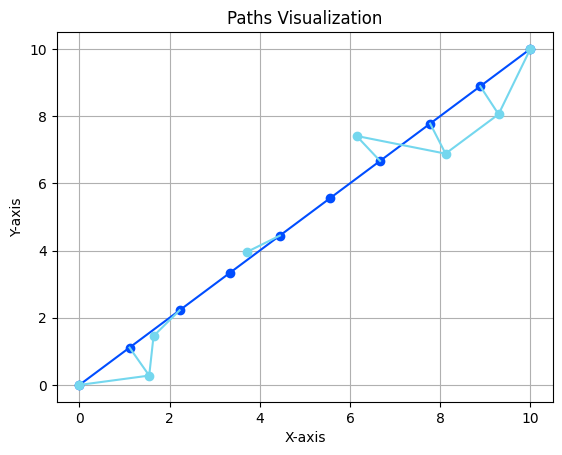

In [20]:
# Settings for the paths.
end_x = 10.0
end_y = 10.0
points = 10

graph_style_main = GraphStyle(line_color='#004DFF', line_style='-', node_color='#004DFF', node_shape='o')
graph_style_alt = GraphStyle(line_color='#74D7EE', line_style='-', node_color='#74D7EE', node_shape='o')
graph_styles_paths = [graph_style_main, graph_style_alt]

fuzz_distance_main = 0.0
fuzz_distance_alt = 1.0
fuzz_distribution_main = stats.beta(a=4, b=5)
fuzz_distribution_alt = stats.beta(a=30, b=4)

# Create start/end nodes.
start = Node(0.0, 0.0)
end = Node(end_x, end_y)

# Create the paths.
path_a = create_fuzzed_path(start, end, num_points=points, intensity=fuzz_distance_main, distribution=fuzz_distribution_main)
path_b = create_fuzzed_path(start, end, num_points=points, intensity=fuzz_distance_alt, distribution=fuzz_distribution_alt)

# Cross-connect the paths, delete random nodes, then clean the nodes up.
path_b.add_edges(cross_connect_paths(path_a, path_b))
path_b.nodes = randomly_delete(path_b.nodes, percent=0.3)
path_b.edges = cleanup_edges(path_b.edges, valid_nodes=path_a.nodes + path_b.nodes)

# Remove any orphaned nodes from the alt path.
cleanup_orphaned_nodes(path_a, [path_b])

# Display the paths.
paths = [path_a, path_b]
axis = plot_paths(paths, graph_styles_paths)
plt.show()